In [2]:
import numpy as np

def meanfield_rates_stationary(beta_X, beta_Y, aXX, aXY, aYX, aYY, muXl, muYl):
    A = np.array([[-beta_X + aXX, aXY],
                  [ aYX,          -beta_Y + aYY]], dtype=float)
    b = np.array([beta_X*muXl, beta_Y*muYl], dtype=float)
    lam_inf = -np.linalg.solve(A, b)
    lam_inf = np.maximum(lam_inf, 1e-12)  # clip for safety
    return lam_inf[0], lam_inf[1]

def build_jump_recursion(eta, delta, dh):
    """
    For kernel g(j)=eta*exp(-eta*(j-delta))*1_{j>=delta},
    convolution C_i = sum_{k=m..i} S_{i-k} * g(k*dh) * dh
    can be computed via:
        C_i = a*C_{i-1} + alpha * S_{i-m},   for i >= m,
        C_i = 0 for i < m,
    where:
        m = ceil(delta/dh),
        a = exp(-eta*dh),
        alpha = eta * exp( eta*(m*dh - delta) ) * dh.
    """
    m = int(np.ceil(delta / dh))
    a = np.exp(-eta * dh)
    alpha = eta * np.exp(eta * (m*dh - delta)) * dh
    return m, a, alpha

def jump_convolution_recursive(S, m, a, alpha):
    """
    Compute C_i = (g * S)_i (one-sided conv) via EMA-like recursion.
    S is 1D array over h-grid.
    """
    n = S.size
    C = np.zeros_like(S)
    # Start at i = m
    acc = 0.0
    for i in range(m, n):
        # add S_{i-m}; decay previous
        acc = a*acc + alpha * S[i - m]
        C[i] = acc
    # for i < m, kernel support doesn't reach: C[i]=0
    return C

def solve_survival_IMEX(
    Hmax, Tmax, Nh, Nt,
    mu_h, sigma_h,
    eta_X, delta_X, eta_Y, delta_Y,
    lamX, lamY,
    upwind=True
):
    """
    IMEX FD for survival S(t,h): implicit (diff+drift), explicit jumps.
    Returns S over time (Nt+1, Nh+1) and spatial grid h, time grid t.
    """
    # grids
    dh = Hmax / Nh
    dt = Tmax / Nt
    h = np.linspace(0.0, Hmax, Nh+1)
    t = np.linspace(0.0, Tmax, Nt+1)

    # initial S at t=0: 1 except boundary
    S = np.ones(Nh+1)
    S[0] = 0.0
    S[-1] = 1.0

    # Precompute jump recursion coefficients
    mX, aX, alphaX = build_jump_recursion(eta_X, delta_X, dh)
    mY, aY, alphaY = build_jump_recursion(eta_Y, delta_Y, dh)

    # Tridiagonal coefficients for implicit local operator
    # Diffusion constants
    if sigma_h < 0: raise ValueError("sigma_h must be >= 0")
    gam = 0.5 * sigma_h**2 * dt / dh**2  # diffusion factor

    # Drift upwind
    mu = mu_h
    if upwind:
        if mu >= 0:
            # backward (upwind): (u_i - u_{i-1})/dh
            up_a = - (mu * dt / dh)    # contributes to diag
            up_below = + (mu * dt / dh)  # contributes to sub-diag
            up_above = 0.0
        else:
            # forward (upwind): (u_{i+1} - u_i)/dh
            up_a = + (abs(mu) * dt / dh)   # diag
            up_below = 0.0
            up_above = - (abs(mu) * dt / dh)  # super-diag
    else:
        # centered drift (conditionally stable; not recommended if |mu| large)
        up_a = 0.0
        up_below = -0.5 * (mu * dt / dh)
        up_above = +0.5 * (mu * dt / dh)

    # Build static tridiagonal LHS matrix (interior nodes 1..Nh-1)
    N = Nh - 1
    a_sub = -gam + up_below * np.ones(N-1)   # lower diagonal
    b_diag = (1.0 + 2*gam + up_a) * np.ones(N)  # center
    c_sup = -gam + up_above * np.ones(N-1)   # upper diagonal

    # Thomas solver (tridiagonal)
    def solve_tridiag(a, b, c, d):
        """Solve tridiagonal system with vectors a (sub), b (diag), c (sup)."""
        nc = len(b)
        cp = np.empty(nc-1); dp = np.empty(nc)
        bp = b.copy()
        cp[0] = c[0] / bp[0]
        dp[0] = d[0] / bp[0]
        for i in range(1, nc-1):
            denom = bp[i] - a[i-1] * cp[i-1]
            cp[i] = c[i] / denom
            dp[i] = (d[i] - a[i-1] * dp[i-1]) / denom
        dp[nc-1] = (d[nc-1] - a[nc-2] * dp[nc-2]) / (bp[nc-1] - a[nc-2] * cp[nc-2])
        x = np.empty(nc)
        x[-1] = dp[-1]
        for i in range(nc-2, -1, -1):
            x[i] = dp[i] - cp[i] * x[i+1]
        return x

    # storage if you want all times
    S_all = np.empty((Nt+1, Nh+1))
    S_all[0, :] = S.copy()

    # time marching
    for n in range(Nt):
        # Explicit jump term at time step n
        CX = jump_convolution_recursive(S, mX, aX, alphaX)
        CY = jump_convolution_recursive(S, mY, aY, alphaY)
        J = lamX * (CX - S) + lamY * (CY - S)

        # Right-hand side for interior nodes
        rhs = S[1:-1] + dt * J[1:-1]

        # Dirichlet BCs at new time (implicit): S_new[0]=0, S_new[-1]=1
        # Incorporate boundary into rhs via diffusion & drift coefficients
        rhs[0]   -= a_sub[0]   * 0.0                 # S_new[0] = 0
        rhs[-1]  -= c_sup[-1]  * 1.0                 # S_new[-1] = 1

        # Solve tridiagonal for interior
        S_new_int = solve_tridiag(a_sub, b_diag, c_sup, rhs)

        # Update full S
        S[1:-1] = S_new_int
        S[0] = 0.0
        S[-1] = 1.0

        S_all[n+1, :] = S

    return t, h, S_all

def survival_to_cdf(S_all):
    return 1.0 - S_all  # F(T,h) = 1 - S(T,h)


In [4]:
# Example parameters (mean-field static lambdas from Hawkes)
mu_X, mu_Y = 0.04, 0.02
sigma_h = 0.25
mu_h = mu_X - mu_Y - 0.5*sigma_h**2  # drift of log-health

beta_X, beta_Y = 2.0, 2.0
aXX, aXY, aYX, aYY = 0.3, 0.1, 0.1, 0.3
muXl, muYl = 0.1, 0.1
lamX, lamY = meanfield_rates_stationary(beta_X, beta_Y, aXX, aXY, aYX, aYY, muXl, muYl)

eta_X, eta_Y = 5.0, 5.0
delta_X, delta_Y = 0.05, 0.05

# Grids
Hmax = 5.0           # max log-health distance (≈ log(1/LTV_min))
Tmax = 10.0          # horizon in the same time units as params
Nh, Nt = 1500, 1500  # grid sizes (tweak for accuracy vs. speed)

t, h, S_all = solve_survival_IMEX(
    Hmax, Tmax, Nh, Nt,
    mu_h, sigma_h,
    eta_X, delta_X, eta_Y, delta_Y,
    lamX, lamY,
)

F_all = survival_to_cdf(S_all)

# Query any meshgrid point
# e.g., initial LTV -> h0 = log(1/LTV), time T -> nearest indices:
LTVs = np.linspace(0.3, 0.9, 7)
Ts = np.linspace(0.5, 8.0, 10)
for LTV in LTVs:
    h0 = np.log(1.0/LTV)
    i = int(round(h0 / (h[1]-h[0])))
    i = min(max(i, 0), len(h)-1)
    for T in Ts[:3]:
        n = int(round(T / (t[1]-t[0])))
        n = min(max(n, 0), len(t)-1)
        print(f"LTV={LTV:.2f} T={T:.2f}  F≈{F_all[n,i]:.4f}")
    print("----")


LTV=0.30 T=0.50  F≈0.0000
LTV=0.30 T=1.33  F≈0.0043
LTV=0.30 T=2.17  F≈0.0170
----
LTV=0.40 T=0.50  F≈0.0030
LTV=0.40 T=1.33  F≈0.0214
LTV=0.40 T=2.17  F≈0.0604
----
LTV=0.50 T=0.50  F≈0.0104
LTV=0.50 T=1.33  F≈0.0633
LTV=0.50 T=2.17  F≈0.1445
----
LTV=0.60 T=0.50  F≈0.0288
LTV=0.60 T=1.33  F≈0.1523
LTV=0.60 T=2.17  F≈0.2751
----
LTV=0.70 T=0.50  F≈0.0860
LTV=0.70 T=1.33  F≈0.3030
LTV=0.70 T=2.17  F≈0.4414
----
LTV=0.80 T=0.50  F≈0.2526
LTV=0.80 T=1.33  F≈0.5116
LTV=0.80 T=2.17  F≈0.6279
----
LTV=0.90 T=0.50  F≈0.5735
LTV=0.90 T=1.33  F≈0.7509
LTV=0.90 T=2.17  F≈0.8158
----


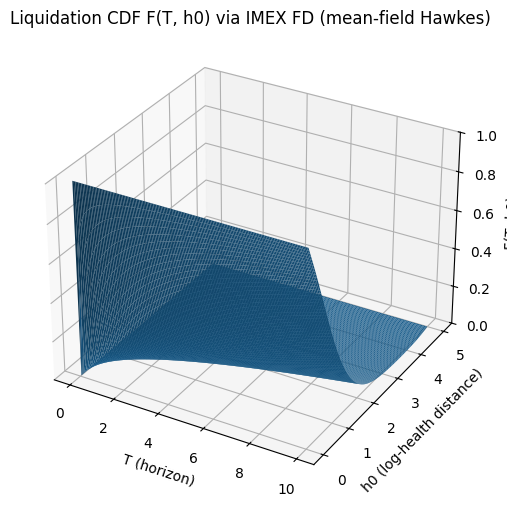

In [5]:
import matplotlib.pyplot as plt
t, h, S_all = solve_survival_IMEX(
    Hmax, Tmax, Nh, Nt,
    mu_h, sigma_h,
    eta_X, delta_X, eta_Y, delta_Y,
    lamX, lamY,
)
F_all = 1.0 - S_all  # CDF

# --- 3D interactive surface plot ---
T_mesh, H_mesh = np.meshgrid(t, h, indexing='xy')   # T along x, h along y
Z = F_all.T  # [time, space] -> transpose to match mesh

# Downsample for plotting speed if needed
stride_t = max(1, len(t)//150)
stride_h = max(1, len(h)//150)
T_plot = T_mesh[::stride_h, ::stride_t]
H_plot = H_mesh[::stride_h, ::stride_t]
Z_plot = Z[::stride_h, ::stride_t]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T_plot, H_plot, Z_plot, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax.set_xlabel('T (horizon)')
ax.set_ylabel('h0 (log-health distance)')
ax.set_zlabel('F(T, h0)')
ax.set_title('Liquidation CDF F(T, h0) via IMEX FD (mean-field Hawkes)')
ax.set_zlim(0, 1)
plt.show()


In [6]:
import numpy as np

# ---------- grids ----------
def make_grids(Hmax, Tmax, Nh, Nt, Lx_max, Ly_max, Nlx, Nly):
    dh = Hmax / Nh; dt = Tmax / Nt
    dLx = Lx_max / Nlx; dLy = Ly_max / Nly
    h  = np.linspace(0, Hmax, Nh+1)
    t  = np.linspace(0, Tmax, Nt+1)
    Lx = np.linspace(0, Lx_max, Nlx+1)
    Ly = np.linspace(0, Ly_max, Nly+1)
    return h, t, Lx, Ly, dh, dt, dLx, dLy

# ---------- jump kernel recursion for shifted exponential ----------
def build_jump_recursion(eta, delta, dh):
    m = int(np.ceil(delta / dh))                    # index offset
    a = np.exp(-eta * dh)                           # EMA decay
    alpha = eta * np.exp(eta * (m*dh - delta)) * dh # EMA injection
    return m, a, alpha

def jump_conv_ema(S_h, m, a, alpha):
    C = np.zeros_like(S_h)
    acc = 0.0
    for i in range(m, S_h.size):
        acc = a*acc + alpha * S_h[i-m]
        C[i] = acc
    return C

# ---------- bilinear interpolation helper on lambda-grid ----------
def bilinear_interp(S, Lx_grid, Ly_grid, lx, ly):
    # S shape: (Nlx+1, Nly+1, Nh+1); interpolate only in lambda dims
    Nlx = Lx_grid.size - 1; Nly = Ly_grid.size - 1
    lx = np.clip(lx, Lx_grid[0], Lx_grid[-1] - 1e-12)
    ly = np.clip(ly, Ly_grid[0], Ly_grid[-1] - 1e-12)
    i = np.minimum(np.searchsorted(Lx_grid, lx) - 1, Nlx-1)
    j = np.minimum(np.searchsorted(Ly_grid, ly) - 1, Nly-1)
    x0, y0 = Lx_grid[i], Ly_grid[j]
    tx = (lx - x0) / (Lx_grid[i+1] - x0)
    ty = (ly - y0) / (Ly_grid[j+1] - y0)
    # broadcast over h
    A = S[i,  j,  :]
    B = S[i+1,j,  :]
    C = S[i,  j+1,:]
    D = S[i+1,j+1,:]
    return (1-ty)*((1-tx)*A + tx*B) + ty*((1-tx)*C + tx*D)

# ---------- tridiagonal solver ----------
def solve_tridiag(a_sub, b_diag, c_sup, rhs):
    n = b_diag.size
    cp = np.empty(n-1); dp = np.empty(n)
    bp = b_diag.copy()
    cp[0] = c_sup[0] / bp[0]
    dp[0] = rhs[0] / bp[0]
    for k in range(1, n-1):
        den = bp[k] - a_sub[k-1]*cp[k-1]
        cp[k] = c_sup[k] / den
        dp[k] = (rhs[k] - a_sub[k-1]*dp[k-1]) / den
    dp[n-1] = (rhs[n-1] - a_sub[n-2]*dp[n-2]) / (bp[n-1] - a_sub[n-2]*cp[n-2])
    x = np.empty(n); x[-1] = dp[-1]
    for k in range(n-2, -1, -1):
        x[k] = dp[k] - cp[k]*x[k+1]
    return x

# ---------- main 3D solver ----------
def solve_survival_3d(
    Hmax, Tmax, Nh, Nt,
    Lx_max, Ly_max, Nlx, Nly,
    mu_h, sigma_h,
    beta_X, beta_Y, muX_lam, muY_lam,
    eta_X, delta_X, eta_Y, delta_Y,
    aXX, aXY, aYX, aYY
):
    h, t, Lx, Ly, dh, dt, dLx, dLy = make_grids(Hmax, Tmax, Nh, Nt, Lx_max, Ly_max, Nlx, Nly)

    # State array: S(lx,ly,h). Init IC
    S = np.ones((Nlx+1, Nly+1, Nh+1), dtype=np.float64)
    S[:, :, 0]  = 0.0
    S[:, :, -1] = 1.0

    # IMEX local operator in h (same for all lambda cells)
    gam = 0.5 * sigma_h**2 * dt / dh**2
    mu  = mu_h
    # upwind in h-drift
    if mu >= 0:
        up_a = - (mu*dt/dh); up_below = + (mu*dt/dh); up_above = 0.0
    else:
        up_a = + (abs(mu)*dt/dh); up_below = 0.0; up_above = - (abs(mu)*dt/dh)
    Nint = Nh - 1
    a_sub = (-gam + up_below) * np.ones(Nint-1)
    b_diag = (1.0 + 2*gam + up_a) * np.ones(Nint)
    c_sup  = (-gam + up_above) * np.ones(Nint-1)

    # Jump recursions in h
    mX, aX, alphaX = build_jump_recursion(eta_X, delta_X, dh)
    mY, aY, alphaY = build_jump_recursion(eta_Y, delta_Y, dh)

    # Time stepping
    for n in range(Nt):
        # 1) semi-Lagrangian advection in lambda
        S_adv = np.empty_like(S)
        for ix, lx in enumerate(Lx):
            for iy, ly in enumerate(Ly):
                aXlam = beta_X*(muX_lam - lx)
                aYlam = beta_Y*(muY_lam - ly)
                lx_dep = lx - aXlam*dt
                ly_dep = ly - aYlam*dt
                S_adv[ix, iy, :] = bilinear_interp(S, Lx, Ly, lx_dep, ly_dep)

        # 2) explicit jumps (nonlocal in h, shifts in lambda)
        J_term = np.zeros_like(S_adv)
        # precompute jump targets in lambda with bounded shifts
        for ix, lx in enumerate(Lx):
            for iy, ly in enumerate(Ly):
                # type X jump shifts lambda -> (lx+aXX, ly+aYX)
                S_shift_X = bilinear_interp(S_adv, Lx, Ly, lx + aXX, ly + aYX)
                # type Y jump shifts lambda -> (lx+aXY, ly+aYY)
                S_shift_Y = bilinear_interp(S_adv, Lx, Ly, lx + aXY, ly + aYY)

                # h-convolution via EMA
                Cx = jump_conv_ema(S_shift_X, mX, aX, alphaX)
                Cy = jump_conv_ema(S_shift_Y, mY, aY, alphaY)

                # current lambdas at this node drive intensities
                lamX = lx
                lamY = ly
                J = lamX*(Cx - S_adv[ix, iy, :]) + lamY*(Cy - S_adv[ix, iy, :])
                J_term[ix, iy, :] = J

        # 3) implicit h-solve per (lx,ly)
        S_new = np.empty_like(S)
        for ix in range(Nlx+1):
            for iy in range(Nly+1):
                rhs = S_adv[ix, iy, 1:-1] + dt*J_term[ix, iy, 1:-1]
                rhs[0]   -= a_sub[0]   * 0.0   # S_new[:, :, 0] = 0
                rhs[-1]  -= c_sup[-1]  * 1.0   # S_new[:, :, -1] = 1
                S_int = solve_tridiag(a_sub, b_diag, c_sup, rhs)
                S_new[ix, iy, 1:-1] = S_int
                S_new[ix, iy, 0]    = 0.0
                S_new[ix, iy, -1]   = 1.0

        S = S_new

    return t, h, Lx, Ly, S  # survival; CDF = 1 - S


T = 4.0
LTV=0.15, h0=1.897, F≈0.4916
LTV=0.25, h0=1.386, F≈0.7896
LTV=0.40, h0=0.916, F≈0.9333
LTV=0.60, h0=0.511, F≈0.9830
LTV=0.80, h0=0.223, F≈0.9959


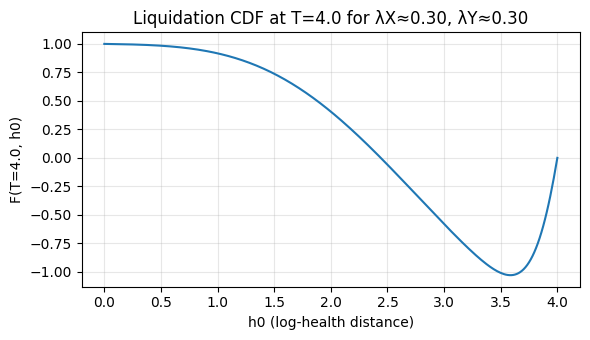

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- choose params (same style as before) ---
mu_X, mu_Y = 0.04, 0.02
sigma_h = 0.25
mu_h = mu_X - mu_Y - 0.5*sigma_h**2

beta_X, beta_Y = 2.0, 2.0
aXX, aXY, aYX, aYY = 0.3, 0.1, 0.1, 0.3
muX_lam, muY_lam = 0.1, 0.1

eta_X, eta_Y = 5.0, 5.0
delta_X, delta_Y = 0.05, 0.05

# --- grids ---
Hmax, Nh = 4.0, 256      # h-domain and resolution
Tmax, Nt = 4.0, 300      # final horizon (single T) and time steps
Lx_max, Ly_max = 1.5, 1.5
Nlx, Nly = 40, 40

# --- run the 3D solver (returns survival S at final T over (h, λx, λy)) ---
t, h, Lx, Ly, S = solve_survival_3d(
    Hmax, Tmax, Nh, Nt,
    Lx_max, Ly_max, Nlx, Nly,
    mu_h, sigma_h,
    beta_X, beta_Y, muX_lam, muY_lam,
    eta_X, delta_X, eta_Y, delta_Y,
    aXX, aXY, aYX, aYY
)

# Pick a lambda slice (e.g., around the baseline means)
lamX0, lamY0 = 0.3, 0.3
ix = int(np.argmin(np.abs(Lx - lamX0)))
iy = int(np.argmin(np.abs(Ly - lamY0)))

# Liquidation CDF at T = Tmax for this lambda slice
F_final = 1.0 - S[ix, iy, :]  # shape (Nh+1,) over h

# --- print F(Tmax, h0) for a few LTVs ---
print("T =", Tmax)
for LTV in [0.15, 0.25, 0.4, 0.6, 0.8]:
    h0 = np.log(1.0/LTV)
    i = int(np.clip(round(h0 / (h[1]-h[0])), 0, len(h)-1))
    print(f"LTV={LTV:.2f}, h0={h0:.3f}, F≈{F_final[i]:.4f}")

# --- quick heatmap: F(Tmax, h0) vs h0 ---
plt.figure(figsize=(6,3.5))
plt.plot(h, F_final)
plt.xlabel("h0 (log-health distance)")
plt.ylabel(f"F(T={Tmax}, h0)")
plt.title(f"Liquidation CDF at T={Tmax} for λX≈{Lx[ix]:.2f}, λY≈{Ly[iy]:.2f}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
